# ML Models

In [171]:
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import classification_report
import pandas as pd  
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns

In [172]:
def read_data():
    df = pd.read_csv("https://gist.githubusercontent.com/cloudwalk-tests/76993838e65d7e0f988f40f1b1909c97/raw/295d9f7cb8fdf08f3cb3bdf1696ab245d5b5c1c9/transactional-sample.csv") 

    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df['has_cbk'] = df['has_cbk'].map({True:1, False:0}) #Label encoding  
    df['ts'] = ((df['transaction_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")) 
    return df

In [173]:
df = read_data()

In [174]:
df.head(3)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,ts
0,21320398,29744,97051,434505******9116,2019-12-01 23:16:32.812632,374.56,285475.0,0,1575242192
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:37.873639,734.87,497105.0,1,1575240337
2,21320400,47759,14777,425850******7024,2019-12-01 22:22:43.021495,760.36,NaN,0,1575238963


# 0. Train-Test Split

In [175]:
features = ['transaction_amount', 'ts'] 
target = ['has_cbk']

X, y = df[features], df[target] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# 1. Fitting some Models

In [176]:

#Logistic Regression 
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
]) 

lr_pipeline.fit(X_train, y_train['has_cbk']) 
y_pred_lr = lr_pipeline.predict(X_test) 

#Logistic Regression L1 
lr_pipeline_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(l1_ratio=0, solver='saga', max_iter=200)) 
]) 

lr_pipeline_2.fit(X_train, y_train['has_cbk']) 
y_pred_lr2 = lr_pipeline_2.predict(X_test) 

# Random Forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train['has_cbk'])
y_pred_rf = rf_clf.predict(X_test)

# Random Forest class weight
rf_clf_2 = RandomForestClassifier(class_weight = 'balanced')
rf_clf_2.fit(X_train, y_train['has_cbk'])
y_pred_rf_2 = rf_clf_2.predict(X_test)

# Complement NB
cnb_clf = ComplementNB()
cnb_clf.fit(X_train, y_train['has_cbk'])
y_pred_cnb = cnb_clf.predict(X_test) 
y_probs_cnb = cnb_clf.predict_proba(X_test)[:, 1]

# DecisionTree 
dt_clf = DecisionTreeClassifier() 
dt_clf.fit(X_train, y_train) 
y_pred_dt = dt_clf.predict(X_test)

In [7]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       562
           1       0.47      0.10      0.17        78

    accuracy                           0.88       640
   macro avg       0.68      0.54      0.55       640
weighted avg       0.84      0.88      0.84       640



In [8]:
print(classification_report(y_test, y_pred_lr2))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       562
           1       0.47      0.10      0.17        78

    accuracy                           0.88       640
   macro avg       0.68      0.54      0.55       640
weighted avg       0.84      0.88      0.84       640



In [9]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       562
           1       0.53      0.26      0.34        78

    accuracy                           0.88       640
   macro avg       0.71      0.61      0.64       640
weighted avg       0.86      0.88      0.86       640



In [10]:
print(classification_report(y_test, y_pred_rf_2))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       562
           1       0.54      0.24      0.34        78

    accuracy                           0.88       640
   macro avg       0.72      0.61      0.64       640
weighted avg       0.86      0.88      0.86       640



In [181]:
print(classification_report(y_test, y_pred_cnb))

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       562
           1       0.27      0.60      0.38        78

    accuracy                           0.76       640
   macro avg       0.60      0.69      0.61       640
weighted avg       0.85      0.76      0.79       640



# 2. Feature Engineering for Tree Models

In [182]:
def create_features(df) -> pd.DataFrame:
    df['last_transaction_amount'] = df.groupby("user_id")['transaction_amount'].shift() 
    df['last_transaction_amount_diff'] = df.groupby("user_id")['transaction_amount'].diff() 
    df['ts_diff'] = df.groupby("user_id")['ts'].diff() 
    df['single_tx_user'] = (
        df.groupby("user_id")['transaction_id'].transform('nunique') > 1
    ).astype(int) 
    return df 

df_new = create_features(df)

In [183]:
features = ['transaction_amount', 'ts', 'last_transaction_amount_diff', 'ts_diff', 'single_tx_user'] 
target = ['has_cbk']

X_2, y_2 = df_new[features], df_new[target] 

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2, stratify=y)

In [184]:
# Random Forest class weight
rf_clf_3 = RandomForestClassifier(class_weight = 'balanced')
rf_clf_3.fit(X_train2, y_train2['has_cbk'])
y_pred_rf_3 = rf_clf_3.predict(X_test2)
scores = rf_clf_3.predict_proba(X_test2)


In [185]:
print(classification_report(y_test2, y_pred_rf_3))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       562
           1       0.72      0.56      0.63        78

    accuracy                           0.92       640
   macro avg       0.83      0.77      0.79       640
weighted avg       0.91      0.92      0.92       640



In [228]:
idxs = X_test2.index

In [229]:
scores_df = pd.DataFrame(scores, columns=['prob_not_cbk', 'prob_cbk']) 

scores_df = scores_df.merge(X_test2, "left", left_index=True, right_index=True) 
scores_df = scores_df.merge(df_new[['user_id']], "left", right_index=True, left_index=True)

In [259]:
sorted_values = scores_df.sort_values(by="prob_cbk")

In [260]:
sorted_values_with_true = sorted_values.merge(y_test2, "left", right_index=True, left_index=True) 
sorted_values_with_true['cumulative_cbk'] = sorted_values_with_true['has_cbk'].cumsum() 
sorted_values_with_true['lift'] = sorted_values_with_true['cumulative_cbk'] / sorted_values_with_true['has_cbk'].sum()

In [261]:
sorted_values_with_true

,prob_not_cbk,prob_cbk,transaction_amount,ts,last_transaction_amount_diff,ts_diff,single_tx_user,user_id,has_cbk,cumulative_cbk,lift
613,1.00,0.00,495.36,1.575044e+09,-179.58,-96314.0,1.0,7695,1.0,1.0,0.047619
612,1.00,0.00,NaN,NaN,NaN,NaN,NaN,34497,NaN,NaN,NaN
609,1.00,0.00,1413.49,1.575045e+09,NaN,NaN,0.0,153,0.0,1.0,0.047619
8,1.00,0.00,NaN,NaN,NaN,NaN,NaN,81152,NaN,NaN,NaN
6,1.00,0.00,NaN,NaN,NaN,NaN,NaN,25661,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
286,0.11,0.89,NaN,NaN,NaN,NaN,NaN,79725,NaN,NaN,NaN
546,0.09,0.91,NaN,NaN,NaN,NaN,NaN,92131,NaN,NaN,NaN
66,0.09,0.91,NaN,NaN,NaN,NaN,NaN,69540,NaN,NaN,NaN
234,0.05,0.95,NaN,NaN,NaN,NaN,NaN,19117,NaN,NaN,NaN


## Visualization

In [262]:
def build_lift_curve(y_actual, y_pred, 
                     ascending=True,
                     return_ideal_curve=False):
    
    """
    Returns the lift curve from actual (0 or 1) data and
    predicted scores.
    
    Also returns what the ideal lift curve for this problem 
    would be, if return_ideal_curve = True
    """
    
    df = pd.DataFrame({'y_actual': y_actual,
                   'prob_default': y_pred})

    # sort from low to high scores
    df = df.sort_values('prob_default', ascending=ascending)
    
    # build cumulative_default
    df['cumulative_default'] = df['y_actual'].cumsum()
    df['lift'] = df['cumulative_default']/df['y_actual'].sum()

    # create index starting from 0 and normalize
    df = df.reset_index(drop=True).reset_index()
    df['index'] = df['index']/(df['index'].iloc[-1])
    df = df.set_index('index')
    
    if return_ideal_curve:
        df_perfect = df.sort_values('y_actual', ascending=ascending)
        df_perfect['cumulative_default'] = df_perfect['y_actual'].cumsum()
        df_perfect['lift'] = df_perfect['cumulative_default']/df_perfect['cumulative_default'].iloc[-1]
        df_perfect = df_perfect.reset_index(drop=True).reset_index()
        df_perfect['index'] = df_perfect['index']/(df_perfect['index'].iloc[-1])
        df_perfect = df_perfect.set_index('index')
        
        return df['lift'], df_perfect['lift']
    
    return df['lift']

In [263]:
lift, ideal_lift = build_lift_curve(sorted_values_with_true['has_cbk'], sorted_values_with_true['prob_cbk'], True, True)

In [264]:
def plot_lift_curve(lift, ideal_lift, model_name:str):

    plt.subplots(figsize=(5,5))

    # lift curve from the model
    lift.plot(label=model_name)

    # perfect lift
    ideal_lift.plot(xlabel='Index (sorted from lower to higher score)', ylabel='Accumulated defaults', 
                        label='Perfect lift curve', linestyle='--', color='lightblue')

    # random lift
    x = np.linspace(0,1)
    plt.plot(x,x, linestyle='--', label='Random classifier', color='gray')

    plt.legend()
    plt.show()

## Complement Naive Bayes

In [265]:
lift_nb, perfect_lift = build_lift_curve(y_test['has_cbk'], y_pred_cnb, return_ideal_curve=True)

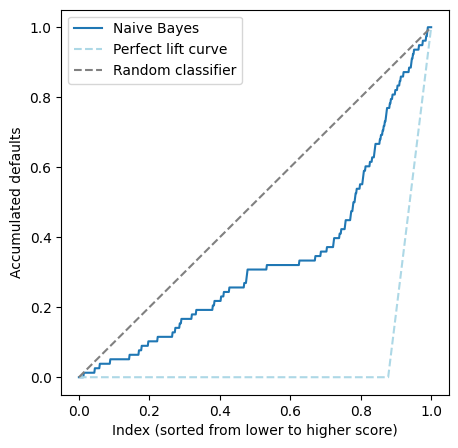

In [266]:
plot_lift_curve(lift_nb, perfect_lift, 'Naive Bayes')

## Random Forest

In [238]:
lift_rf, perfect_lift = build_lift_curve(y_test2['has_cbk'], y_pred_rf_3, return_ideal_curve=True)

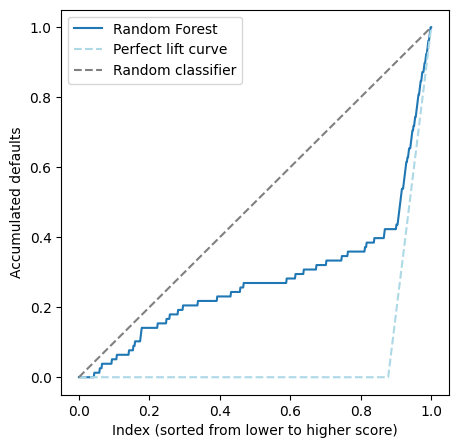

In [267]:
plot_lift_curve(lift_rf, perfect_lift, 'Random Forest')

That's a good model for high probabilities scores. And it's worse for low-probability scores.

## Precision / Recall Curve

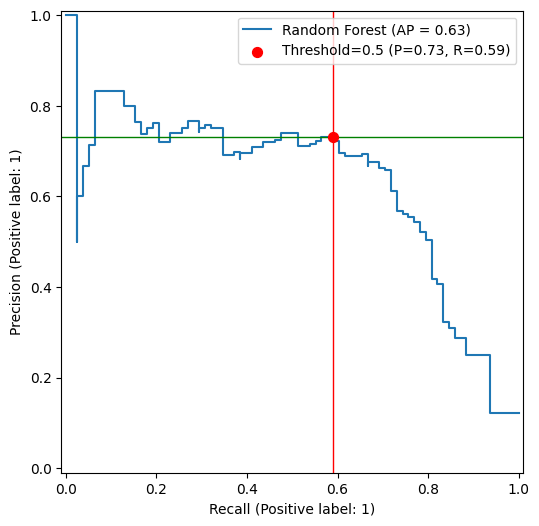

In [298]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
precision, recall, thresholds = precision_recall_curve(
    y_test2['has_cbk'], scores[:,1]) 

fig, ax = plt.subplots(1, 1, figsize=(14,6))

PrecisionRecallDisplay.from_estimator(
    rf_clf_3, X_test2, y_test2, ax = ax, name='Random Forest'
) 

# Add the standard 0.5 cut-off point
idx_cutoff = np.argmin(np.abs(thresholds - 0.5))
ax.scatter(recall[idx_cutoff], precision[idx_cutoff], 
           marker='o', s=50, c='red', zorder=5, 
           label=f'Threshold=0.5 (P={precision[idx_cutoff]:.2f}, R={recall[idx_cutoff]:.2f})')
ax.axvline(recall[idx_cutoff], color='r', linewidth=1)
ax.axhline(precision[idx_cutoff], color='g', linewidth=1)
ax.legend()
plt.show()


## Distribution of Scores

In [331]:
df['has_cbk'].value_counts()

has_cbk
0    2808
1     391
Name: count, dtype: int64

<Axes: xlabel='prob_cbk', ylabel='Count'>

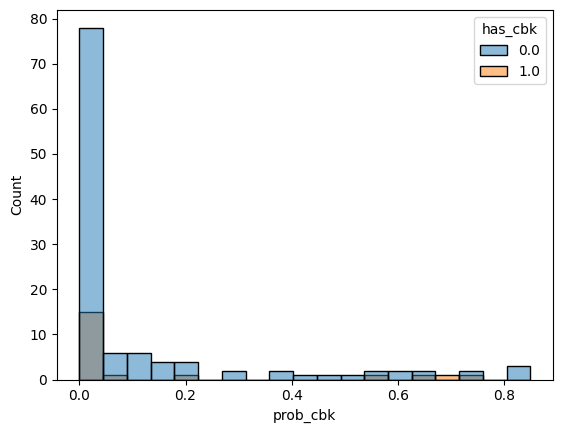

In [268]:
sns.histplot(sorted_values_with_true, x="prob_cbk", hue="has_cbk")

## Dúvida

O lift é o acumulado dos erros. 
Precisa ser sempre necessariamente uniforme? Não. 
Mas, isso é um indício de que os chargebacks podem ter sido gerados de uma distribuição Uniforme

## KS-Score

In [269]:
def ks_score(df_results):
    from scipy.stats import ks_2samp
    z0 = df_results['prob_cbk'][df_results['has_cbk'] == 0]
    z1 = df_results['prob_cbk'][df_results['has_cbk'] == 1] 
    ks = ks_2samp(z0, z1)
    return ks

In [299]:
ks = ks_score(sorted_values_with_true) 
print(ks.statistic, ks.pvalue)

0.11288998357963875 0.9549371493050914


# Random Forest Calibration

In [431]:
sample_weight = np.random.RandomState(42).rand(y.shape[0])

features = ['transaction_amount', 'ts', 'last_transaction_amount_diff', 'ts_diff', 'single_tx_user'] 
target = ['has_cbk']

X_2, y_2 = df_new[features], df_new[target]  


# split train, test for calibration
X_train2, X_test2, y_train2, y_test2, sw_train, sw_test = train_test_split(
    X_2, y_2, sample_weight, test_size=0.2, random_state=42
)


In [433]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV 

# Random Forest class weight - no calibration
rf_clf_3 = RandomForestClassifier(class_weight = 'balanced')
rf_clf_3.fit(X_train2, y_train2['has_cbk'])
y_pred_rf_3 = rf_clf_3.predict(X_test2)
scores = rf_clf_3.predict_proba(X_test2) 

#Random Forest class weight - with calibration
# With sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(rf_clf_3, cv=2, method="sigmoid")
clf_sigmoid.fit(X_train2, y_train2['has_cbk'], sample_weight=sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test2)[:, 1]

# With isotonic calibration
clf_isotonic = CalibratedClassifierCV(rf_clf_3, cv=2, method="isotonic")
clf_isotonic.fit(X_train2, y_train2['has_cbk'], sample_weight=sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test2)[:, 1]

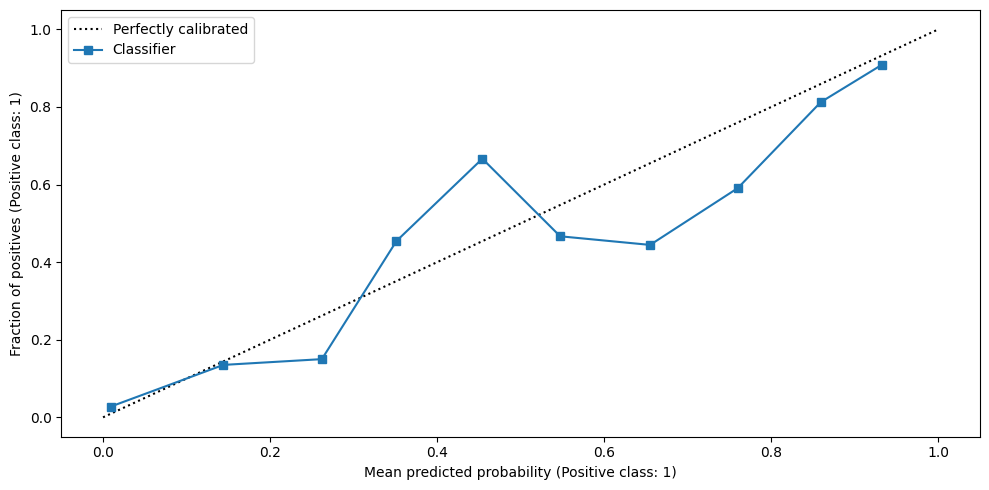

In [434]:
fig, ax = plt.subplots(ncols=1, figsize=(10,5))

CalibrationDisplay.from_predictions(
    y_test2,
    scores[:, 1],
    n_bins=10,
    ax=ax
) 

plt.legend() 
plt.tight_layout() 
plt.show()

Vemos que o modelo está descalibrado para os scores mais altos, subestimando o valor real das probabilidades.

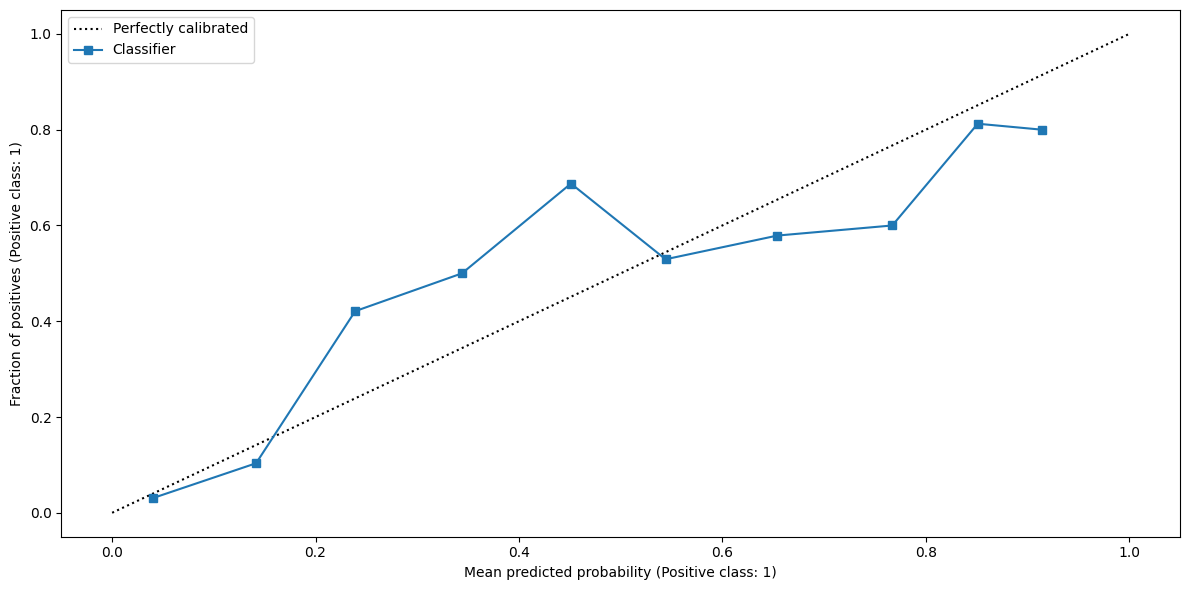

In [435]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))

CalibrationDisplay.from_predictions(
    y_test2,
    prob_pos_sigmoid,
    n_bins=10,
    ax=ax
) 

plt.legend()
plt.tight_layout() 
plt.show()

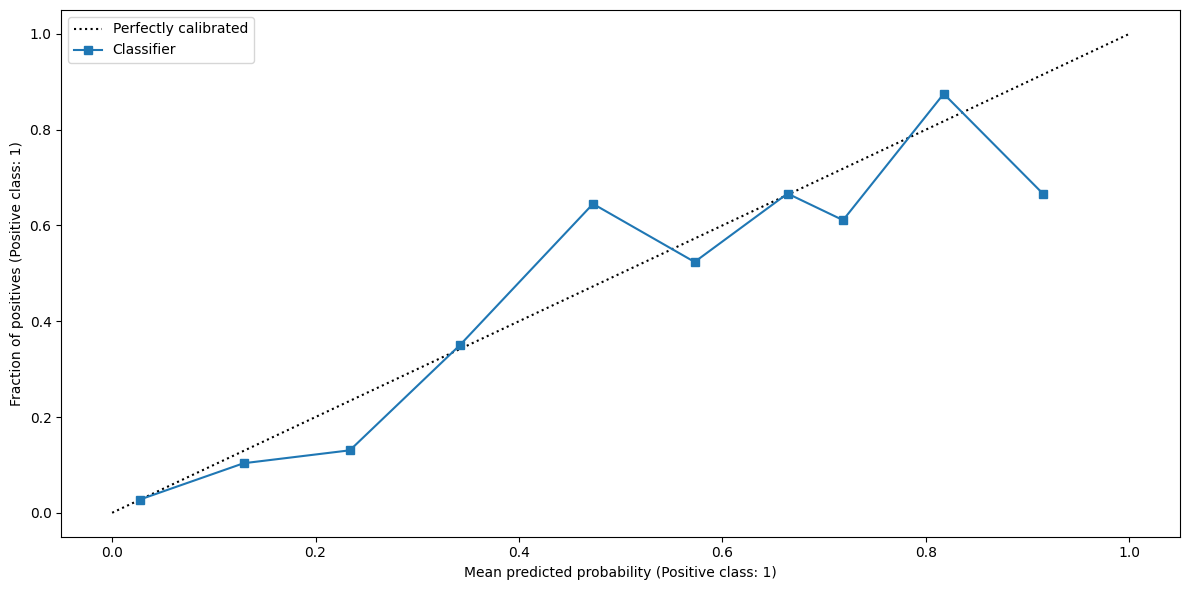

In [436]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))

CalibrationDisplay.from_predictions(
    y_test2,
    prob_pos_isotonic,
    n_bins=10,
    ax=ax
) 

plt.legend()
plt.tight_layout() 
plt.show()

## XGBoost Model

In [437]:
cls_ratio = y_train2['has_cbk'][y_train2['has_cbk'] == 0].count() /  y_train2['has_cbk'][y_train2['has_cbk'] == 1].count()
cls_ratio

np.float64(7.501661129568106)

In [438]:
import xgboost as xgb 

# Use "hist" for constructing the trees, with early stopping enabled.
xgb_clf = xgb.XGBClassifier(tree_method="exact", early_stopping_rounds=2, scale_pos_weight=cls_ratio)
# Fit the model, test sets are used for early stopping.
xgb_clf.fit(X_train2, y_train2, eval_set=[(X_test2, y_test2)])

[0]	validation_0-logloss:0.53781
[1]	validation_0-logloss:0.45301
[2]	validation_0-logloss:0.40547
[3]	validation_0-logloss:0.37600
[4]	validation_0-logloss:0.35068
[5]	validation_0-logloss:0.33749
[6]	validation_0-logloss:0.32866
[7]	validation_0-logloss:0.32152
[8]	validation_0-logloss:0.32211
[9]	validation_0-logloss:0.32068
[10]	validation_0-logloss:0.31748
[11]	validation_0-logloss:0.31596
[12]	validation_0-logloss:0.31588
[13]	validation_0-logloss:0.31551
[14]	validation_0-logloss:0.31422
[15]	validation_0-logloss:0.31120
[16]	validation_0-logloss:0.30982
[17]	validation_0-logloss:0.30786
[18]	validation_0-logloss:0.30763
[19]	validation_0-logloss:0.30525
[20]	validation_0-logloss:0.30406
[21]	validation_0-logloss:0.30551
[22]	validation_0-logloss:0.30542


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",2
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fro

In [440]:
y_pred_xgb = xgb_clf.predict(X_test2)
scores_xgb = xgb_clf.predict_proba(X_test2) 

In [441]:
print(classification_report(y_test2, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       550
           1       0.57      0.76      0.65        90

    accuracy                           0.88       640
   macro avg       0.76      0.83      0.79       640
weighted avg       0.90      0.88      0.89       640



In [442]:
lift_nb, perfect_lift = build_lift_curve(y_test2['has_cbk'], y_pred_xgb, return_ideal_curve=True)

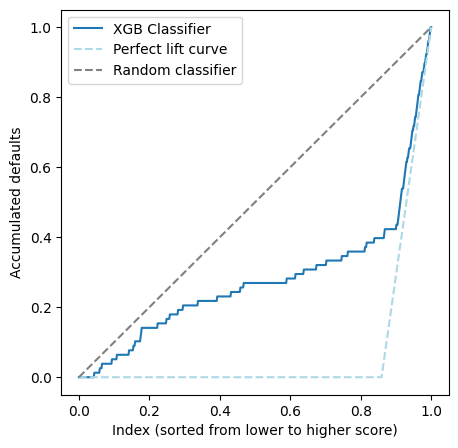

In [443]:
plot_lift_curve(lift_rf, perfect_lift, 'XGB Classifier')

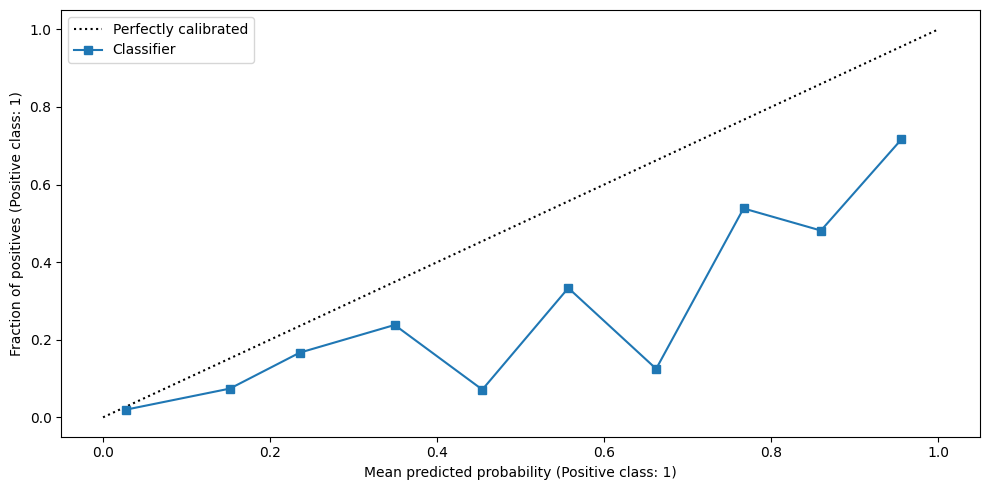

In [444]:
fig, ax = plt.subplots(ncols=1, figsize=(10,5))

CalibrationDisplay.from_predictions(
    y_test2,
    scores_xgb[:, 1],
    n_bins=10,
    ax=ax
) 

plt.legend() 
plt.tight_layout() 
plt.show()

# Wrapping Up

## Confusion Matrix

Confusion matrix, without normalization
Normalized confusion matrix


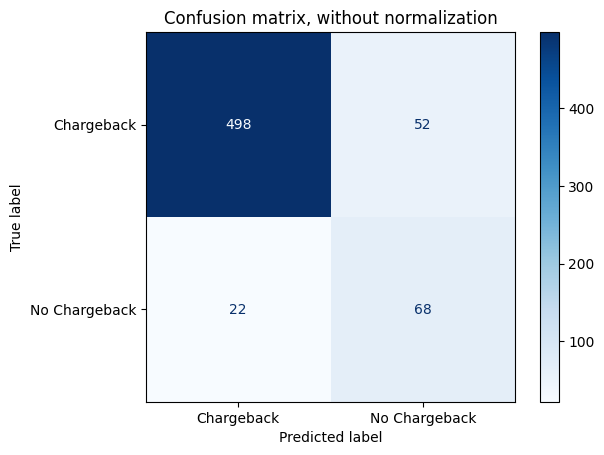

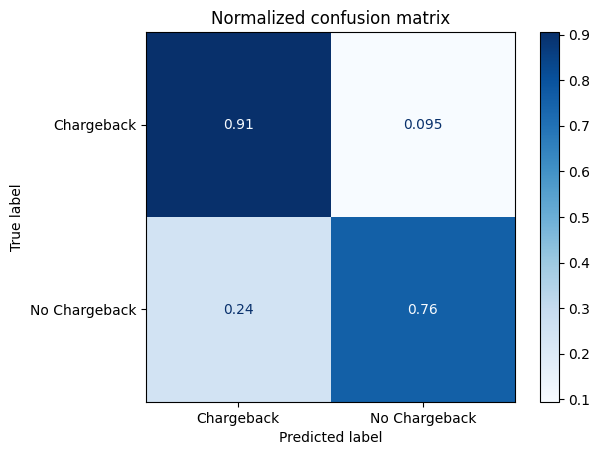

In [445]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Chargeback', 'No Chargeback']

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        xgb_clf,
        X_test2,
        y_test2,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    # print(disp.confusion_matrix)

plt.show()

## Cost-Sensitive Learning

In [477]:
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, recall_score

pos_label, neg_label = 1, 0

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
} 


def credit_gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])

    gain_matrix = np.array(
        [
            [0, -1],  # -1 gain for false positives
            [-5, 0],  # -5 gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)


scoring["credit_gain"] = make_scorer(
    credit_gain_score, neg_label=neg_label, pos_label=pos_label
)

In [478]:
print(f"Business defined metric: {scoring['credit_gain'](xgb_clf, X_test2, y_test2)}")

Business defined metric: -162


## Threshold Tuning 

In [479]:
from sklearn.model_selection import TunedThresholdClassifierCV 
from sklearn.metrics import RocCurveDisplay

# Create XGBoost model without early stopping for threshold tuning
xgb_clf_for_tuning = xgb.XGBClassifier(tree_method="exact", scale_pos_weight=cls_ratio)
xgb_clf_for_tuning.fit(X_train2, y_train2['has_cbk'])

tuned_model = TunedThresholdClassifierCV(
    estimator=xgb_clf_for_tuning,
    scoring=scoring["credit_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train2, y_train2['has_cbk'])
print(f"{tuned_model.best_threshold_=:.3f}")


tuned_model.best_threshold_=0.152


In [482]:
def plot_roc_pr_curves(vanilla_model, tuned_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Vanilla XGB", "Tuned XGB")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((vanilla_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test, y_test),
            scoring["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            curve_kwargs=dict(linestyle=linestyle, color=color),
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test, y_test),
            scoring["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

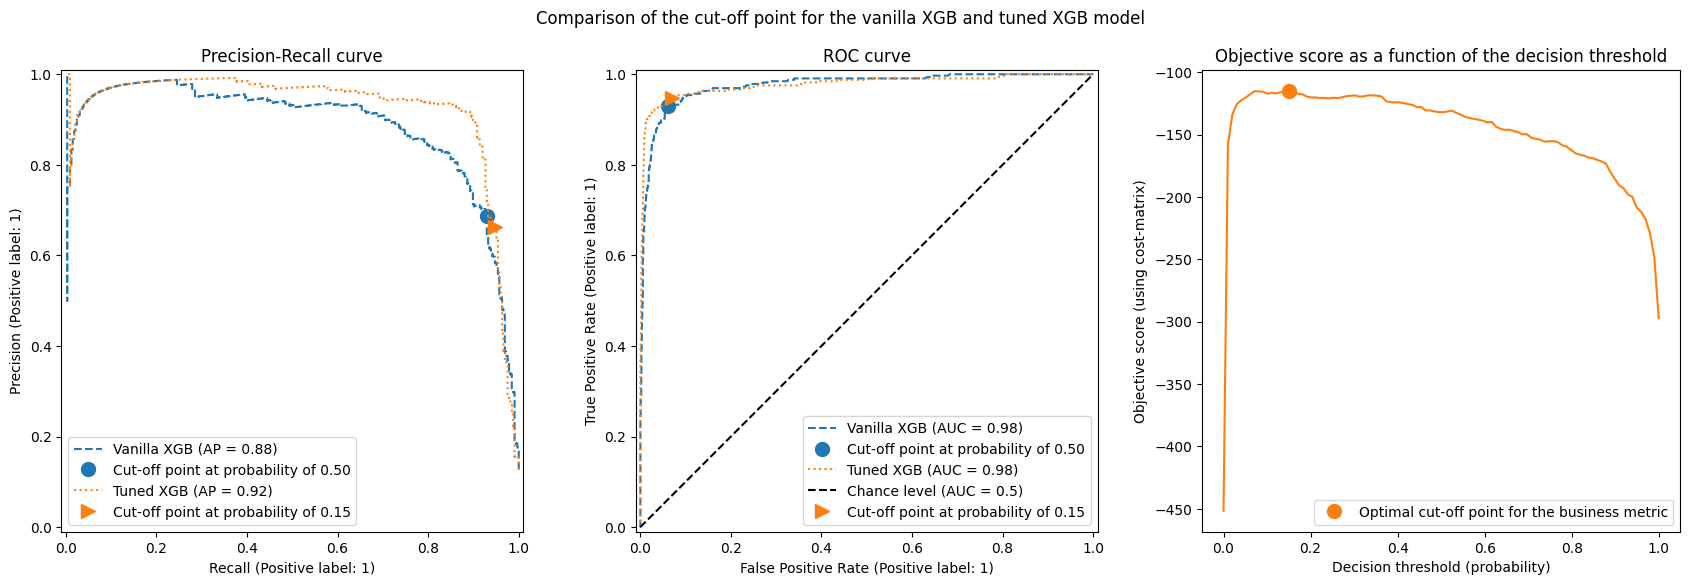

In [483]:
title = "Comparison of the cut-off point for the vanilla XGB and tuned XGB model"
plot_roc_pr_curves(xgb_clf, tuned_model, title=title)

In [484]:
print(f"Business defined metric: {scoring['credit_gain'](tuned_model, X_test2, y_test2)}")

Business defined metric: -153


In [488]:
# Classification Report as DataFrame
from sklearn.metrics import classification_report

# Get predictions from tuned model
y_pred_tuned = tuned_model.predict(X_test2)

# Generate classification report as dictionary
report_dict = classification_report(y_test2, y_pred_tuned, 
                                   target_names=['No Chargeback', 'Chargeback'],
                                   output_dict=True)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report_dict).transpose()

# Format the display
report_df = report_df.round(3)

print("Classification Report - XGBoost Tuned Model")
print("="*60)
display(report_df)


Classification Report - XGBoost Tuned Model


,precision,recall,f1-score,support
No Chargeback,0.966,0.876,0.919,550.000
Chargeback,0.518,0.811,0.632,90.000
accuracy,0.867,0.867,0.867,0.867
macro avg,0.742,0.844,0.776,640.000
weighted avg,0.903,0.867,0.879,640.000


## Confusion Matrix for Tuned Model on Bussiness Metric

Confusion matrix, without normalization
Normalized confusion matrix


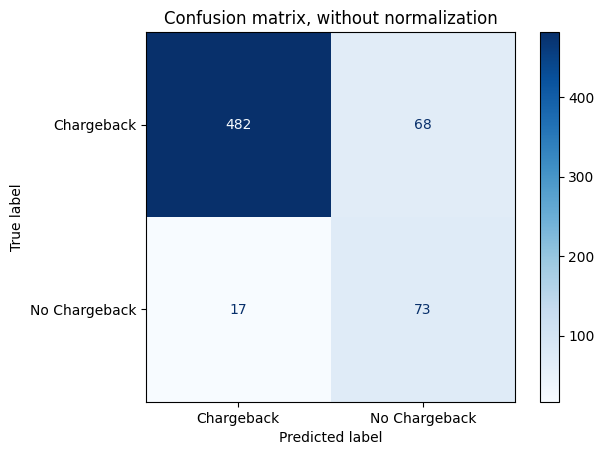

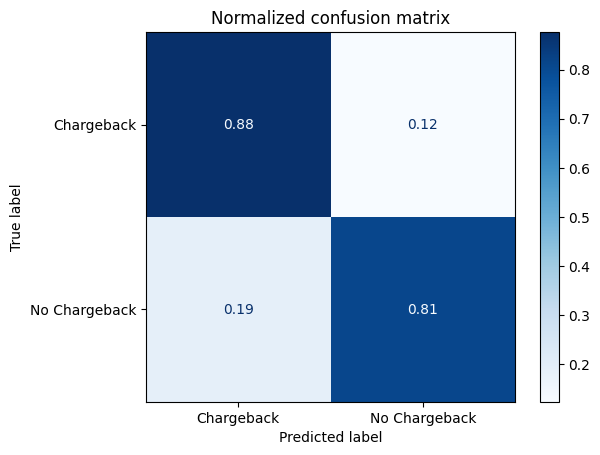

In [485]:
class_names = ['Chargeback', 'No Chargeback']

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        tuned_model,
        X_test2,
        y_test2,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)

plt.show()

### Gain on Optimizing

In [487]:
1 - (scoring['credit_gain'](tuned_model, X_test2, y_test2)/scoring['credit_gain'](xgb_clf, X_test2, y_test2))

np.float64(0.05555555555555558)

5%, approxximately on tuning model on bussiness metric.